In [9]:
import pandas as pd

In [10]:
Data=pd.read_excel("http://data.hossam.kr/E04/diabetes.xlsx")
data=pd.DataFrame(Data)

|변수|설명|
|--|--|
|age|나이|
|sex|성별|
|bmi|비만도|
|bp|평균 혈압|
|s1~s6|종류별 혈액검사 수치|
|target|당뇨병 진행률|

# 1. ETA

In [11]:
target="target"
feature=data.columns.difference([target])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 38.1 KB


In [13]:
import matplotlib.pyplot as plt
import seaborn as sb


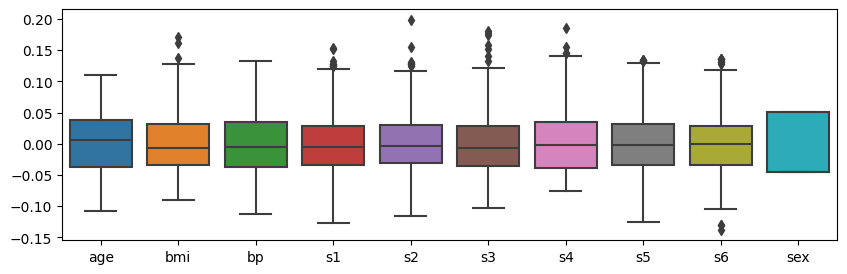

In [14]:
plt.figure(figsize=(10,3))
sb.boxplot(data[feature])
plt.show()
plt.close()

이상치가 꽤 보이지만 일단 진행해보자

## 변수선택

### 산점도 행렬을 먼저 살펴보자

In [15]:
# plt.figure()
# g=sb.pairplot(data,kind='reg')
# plt.show()
# plt.close()

### 피어슨 상관계수

In [16]:
data[data.columns.difference(["target","sex"])].corr(method="pearson").abs().style.background_gradient(cmap="PuBu")

,age,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.000000,0.185085,0.335428,0.260061,0.219243,0.075181,0.203841,0.270774,0.301731
bmi,0.185085,1.000000,0.395411,0.249777,0.261170,0.366811,0.413807,0.446157,0.388680
bp,0.335428,0.395411,1.000000,0.242464,0.185548,0.178762,0.257650,0.393480,0.390430
s1,0.260061,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717
s2,0.219243,0.261170,0.185548,0.896663,1.000000,0.196455,0.659817,0.318357,0.290600
s3,0.075181,0.366811,0.178762,0.051519,0.196455,1.000000,0.738493,0.398577,0.273697
s4,0.203841,0.413807,0.257650,0.542207,0.659817,0.738493,1.000000,0.617859,0.417212
s5,0.270774,0.446157,0.393480,0.515503,0.318357,0.398577,0.617859,1.000000,0.464669
s6,0.301731,0.388680,0.390430,0.325717,0.290600,0.273697,0.417212,0.464669,1.000000


위에서 보다시피 (s1,s2), (s1,s4), (s1,s5), (s2,s4) 등 너무 선형관계를 가지는 독립변수가 많음


### VIF 검사를 실시해보자

In [17]:
import statsmodels.api as sm
numeric_columns=data.columns.difference(["target","sex"])

In [18]:
while True:
    vif_result=[]
    for target_col in numeric_columns:
        temp=sm.OLS(exog=data[[x for x in numeric_columns if x!=target_col]],endog=data[target_col]).fit()
        vif_result.append({'column': target_col,'vif_score':1/(1-temp.rsquared)})
    vif_result.sort(key=lambda x:x["vif_score"],reverse=True)
    if vif_result[0]["vif_score"]<10:
        break
    else:
        numeric_columns=numeric_columns.drop(vif_result[0]["column"])

In [19]:
vif_df=pd.DataFrame(vif_result)

In [20]:
vif_df

,column,vif_score
0,s4,7.782849
1,s3,3.615896
2,s2,2.925747
3,s5,2.146975
4,s6,1.476488
5,bmi,1.472896
6,bp,1.406432
7,age,1.204720


이걸로 다중공선성을 제거, 즉 변수끼리의 선형성을 가지긴 어려운 형태         
또한 다중회귀분석을 실시할 예정으로 PCA를 실시하여 차원축소를 실시하진 않겠음

### 범주형 데이터  : sex 에 대해서 알아봐야한다.
값이 범주로 안나오니 바꿔놓겠다.            
$value$ > 0 : 1

In [21]:
data["sex"]=data["sex"].apply(lambda x:1 if x>0 else 0)

#### 범주형과 연속형의 독립성 검정
이건 회귀분석 결과를 보고 확인하자

### 회귀분석

In [22]:
import sklearn.model_selection as skmod

In [23]:

target="target"
train,test=skmod.train_test_split(data,train_size=0.7,random_state=10)

In [24]:
vif=[x["column"] for x in vif_result]

In [25]:
ols_result_1=sm.OLS(exog=sm.add_constant(train[vif]),endog=train[target]).fit()

In [26]:
ols_result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     38.58
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           6.38e-42
Time:                        10:03:16   Log-Likelihood:                -1666.9
No. Observations:                 309   AIC:                             3352.
Df Residuals:                     300   BIC:                             3385.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.4746      3.086     48.757      0.000     144.401     156.548
s4           339.5455    184.033      1.845      0.066     -22.614     701.705
s3           -48.3791    123.640     -0.391      0.696    -291.691     194.933
s2          -351.6897    115.505     -3.045      0.003    -578.993    -124.386
s5           371.6789     96.410      3.855      0.000     181.954     561.404
s6           104.3179     78.983      1.321      0.188     -51.114     259.749
bmi          582.4511     79.310      7.344      0.000     426.377     738.526
bp           236.9189     78.802      3.007      0.003      81.845     391.993
age           -0.1754     72.738     -0.002      0.998    -143.318     142.967
==============================================================================
Omnibus:                        7.579   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                4.263
Skew:                           0.030   Prob(JB):                        0.119
Kurtosis:                       2.428   Cond. No.                         77.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

age의 p value가 너무 이상하므로 확인해보자

#### 문제확인

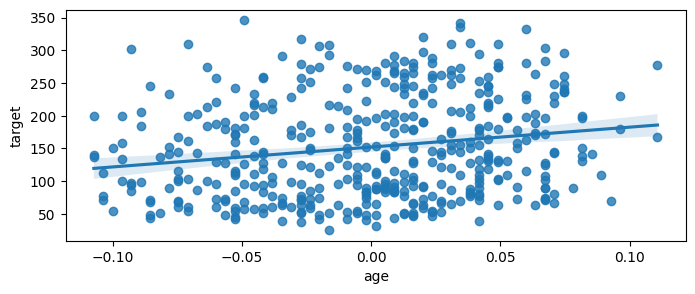

In [27]:
# 시각화
plt.figure(figsize=(8,3))
sb.regplot(data,x="age",y="target")
plt.show()
plt.close()

In [28]:
# pearson corelation : 물론 정규성을 확인하진 않았으므로 주의가 필요 : pvalue를 확인해보자
data[["target","age"]].corr(method='pearson')

,target,age
target,1.000000,0.187889
age,0.187889,1.000000


In [29]:
import scipy.stats as sps

In [30]:
sps.pearsonr(data["target"],data["age"]).pvalue

7.055686149116239e-05

In [31]:
# 회귀분석
model=sm.OLS(exog=sm.add_constant(data["age"]),endog=data["target"]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     16.10
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           7.06e-05
Time:                        10:03:17   Log-Likelihood:                -2539.2
No. Observations:                 442   AIC:                             5082.
Df Residuals:                     440   BIC:                             5091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      3.606     42.192      0.000     145.047     159.220
age          304.1831     75.806      4.013      0.000     155.196     453.170
==============================================================================
Omnibus:                       52.996   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.909
Skew:                           0.438   Prob(JB):                     1.43e-06
Kurtosis:                       2.167   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

여기서 우리가 알수 있는 결론 : age와 target(당뇨병 진행도)사이의 선형성이 약하다 생각

R^2=1-SSR/SST 이므로 SSR/SST=0.965이다.             
즉 오치의 분산이 종속변수 분산 대비 굉장히 크며, 이 회귀모델의 p value값(<0.05)을 보아          
이 모델은 통계적으로 유의미하다(회귀계수의 pvalue값또한 통계적 유의미성을 나타낸다).            
따라서 age와 target간의 선형관계는 설명되기 어렵다

*참고
에러메세지는 잔차와 독립변수사이의 공분산행렬에 문제가 있음을 이야기하지만, dubin watson결과가 2에 가까우므로           
패스

#### age를 제거한 OLS

In [32]:
vif.remove("age")
ols_result_2=sm.OLS(exog=sm.add_constant(train[vif]),endog=train[target]).fit()

In [33]:
ols_result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     44.24
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           9.22e-43
Time:                        10:03:17   Log-Likelihood:                -1666.9
No. Observations:                 309   AIC:                             3350.
Df Residuals:                     301   BIC:                             3380.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.4745      3.081     48.843      0.000     144.412     156.537
s4           339.5487    183.723      1.848      0.066     -21.995     701.092
s3           -48.3825    123.427     -0.392      0.695    -291.271     194.506
s2          -351.7033    115.177     -3.054      0.002    -578.356    -125.050
s5           371.6612     95.969      3.873      0.000     182.807     560.516
s6           104.2839     77.584      1.344      0.180     -48.393     256.960
bmi          582.4547     79.164      7.358      0.000     426.669     738.240
bp           236.8682     75.811      3.124      0.002      87.681     386.055
==============================================================================
Omnibus:                        7.582   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                4.264
Skew:                           0.030   Prob(JB):                        0.119
Kurtosis:                       2.428   Cond. No.                         77.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 문제확인(2)
s3와 target 사이의 선형성 또한 위의 과정을 반복하여 확인

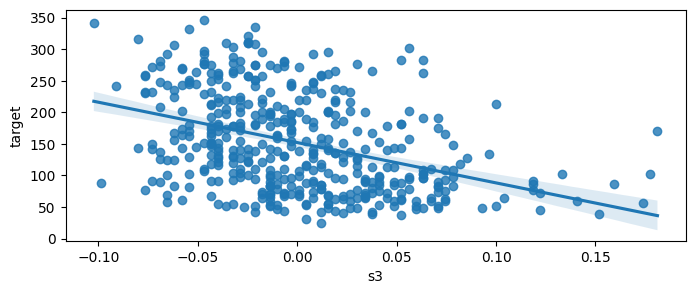

In [34]:
# 시각화
plt.figure(figsize=(8,3))
sb.regplot(data,x="s3",y="target")
plt.show()
plt.close()

In [35]:
# pearson corelation
data[["target","s3"]].corr(method='pearson')

,target,s3
target,1.000000,-0.394789
s3,-0.394789,1.000000


In [36]:
model=sm.OLS(exog=sm.add_constant(data["s3"]),endog=data["target"]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     81.24
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           6.16e-18
Time:                        10:03:17   Log-Likelihood:                -2509.7
No. Observations:                 442   AIC:                             5023.
Df Residuals:                     440   BIC:                             5032.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      3.373     45.105      0.000     145.504     158.762
s3          -639.1453     70.911     -9.013      0.000    -778.512    -499.778
==============================================================================
Omnibus:                       30.490   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.293
Skew:                           0.353   Prob(JB):                     0.000107
Kurtosis:                       2.297   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2$값이 낮게 나옴 -> vif 값 또한 7이상으로 높게 나왔으니(엄밀한 기준에선 5이상은 의심수준이므로) 제거하며 비교해보며 회귀분석을 진행하겠다

### S3 제거 후 회귀분석

In [37]:
vif.remove("s3")
ols_result_3=sm.OLS(exog=sm.add_constant(train[vif]),endog=train[target]).fit()

In [38]:
ols_result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     51.73
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           1.32e-43
Time:                        10:03:17   Log-Likelihood:                -1666.9
No. Observations:                 309   AIC:                             3348.
Df Residuals:                     302   BIC:                             3374.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.4815      3.076     48.915      0.000     144.428     156.535
s4           397.9210    107.457      3.703      0.000     186.462     609.380
s2          -377.9115     93.653     -4.035      0.000    -562.207    -193.616
s5           358.3971     89.680      3.996      0.000     181.921     534.873
s6           104.5551     77.473      1.350      0.178     -47.899     257.009
bmi          588.7574     77.406      7.606      0.000     436.435     741.080
bp           239.1505     75.481      3.168      0.002      90.615     387.686
==============================================================================
Omnibus:                        7.631   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                4.304
Skew:                           0.040   Prob(JB):                        0.116
Kurtosis:                       2.427   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### s4를 제거한 후 실행

In [39]:
vif.append("s3")
vif.remove("s4")
ols_result_4=sm.OLS(exog=sm.add_constant(train[vif]),endog=train[target]).fit()
ols_result_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     50.64
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           6.58e-43
Time:                        10:03:17   Log-Likelihood:                -1668.6
No. Observations:                 309   AIC:                             3351.
Df Residuals:                     302   BIC:                             3377.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.5858      3.092     48.694      0.000     144.500     156.671
s2          -187.3953     73.517     -2.549      0.011    -332.065     -42.726
s5           466.9444     81.268      5.746      0.000     307.022     626.867
s6           110.8997     77.811      1.425      0.155     -42.221     264.020
bmi          572.3818     79.292      7.219      0.000     416.348     728.416
bp           220.4295     75.588      2.916      0.004      71.683     369.176
s3          -233.2722     72.581     -3.214      0.001    -376.100     -90.444
==============================================================================
Omnibus:                        7.237   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                4.114
Skew:                           0.015   Prob(JB):                        0.128
Kurtosis:                       2.436   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

위의 결과를 비교해보자
|구분|$R^2$|AIC|
|--|--|--|
|s3제거|0.507|3348|
|s4제거|0.502|3351|

따라서 s3를 제거 후 p value>0.05 인 s6에 대해서 회귀분석 실시

### s6제거 후 OLS

In [40]:
vif.append("s4")
vif.remove("s6")
vif.remove("s3")
ols_result_5=sm.OLS(exog=sm.add_constant(train[vif]),endog=train[target]).fit()
ols_result_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     61.55
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           3.91e-44
Time:                        10:03:17   Log-Likelihood:                -1667.9
No. Observations:                 309   AIC:                             3348.
Df Residuals:                     303   BIC:                             3370.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.5154      3.080     48.861      0.000     144.454     156.577
s2          -368.4184     93.515     -3.940      0.000    -552.440    -184.397
s5           385.7237     87.482      4.409      0.000     213.574     557.873
bmi          600.2606     77.039      7.792      0.000     448.661     751.860
bp           257.6728     74.324      3.467      0.001     111.417     403.929
s4           411.1354    107.155      3.837      0.000     200.273     621.997
==============================================================================
Omnibus:                        5.217   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                3.371
Skew:                           0.052   Prob(JB):                        0.185
Kurtosis:                       2.499   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

우선 회귀모델엔 문제가 없는 연속형 변수들을 가져옴

## 범주형 데이터 sex의 유무에 따른 회귀모델의 변화를 보자

In [41]:
# 이떄 sex는 이미 dummy화 한것과 마찬가지임
add_vif=vif+["sex"]
ols_result_cate=sm.OLS(exog=sm.add_constant(train[add_vif]),endog=train[target]).fit()
ols_result_cate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     53.63
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           8.47e-45
Time:                        10:03:17   Log-Likelihood:                -1664.1
No. Observations:                 309   AIC:                             3342.
Df Residuals:                     302   BIC:                             3368.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        159.0951      4.375     36.361      0.000     150.485     167.705
s2          -390.0906     92.872     -4.200      0.000    -572.848    -207.333
s5           355.3851     87.272      4.072      0.000     183.648     527.123
bmi          587.6594     76.369      7.695      0.000     437.377     737.941
bp           298.9298     75.076      3.982      0.000     151.192     446.667
s4           499.3575    110.833      4.505      0.000     281.255     717.460
sex          -18.0226      6.594     -2.733      0.007     -30.998      -5.047
==============================================================================
Omnibus:                        1.621   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.451
Skew:                           0.028   Prob(JB):                        0.484
Kurtosis:                       2.669   Cond. No.                         52.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

모델의 성능이 개선됨을 알 수 있다. 하지만 더 높은 성능을 위해 다항회귀분석을 준비해보자         
이때 이상치가 발생해 있는 column들에 대해 고민해보자

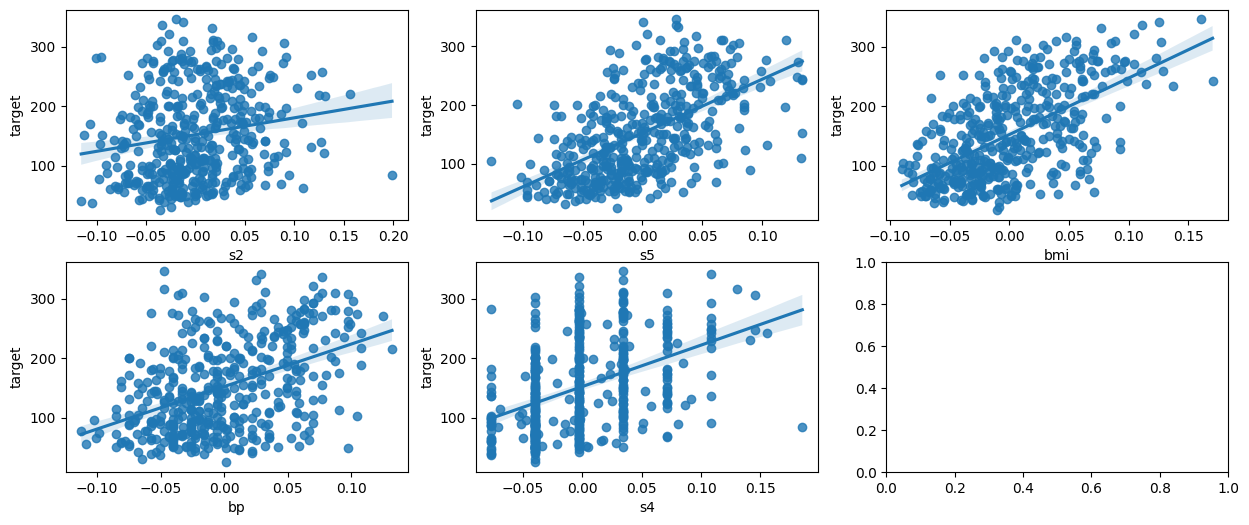

In [42]:
_,a=plt.subplots(2,3,figsize=(15,6))
ax_ls=sum(map(list,a),[])
for i in range(len(ax_ls)-1):
    sb.regplot(data=data,x=vif[i],y='target',ax=ax_ls[i])


### 이거 degree를 예측할 수가 있나.?
grid search가 답일 수 있겠구나 생각이 듦.           
또한 성별에 따른 독립성을 검정하지 않아 p value에 있어 조심해야할듯         
*참고           
grid search -> r^2 값을 최적화하기 위해 파라미터를 대입함

### 2차를 기준으로 생각해보자

사용가능한 column의 조합을 먼저 생각해보자

In [43]:
import sklearn.preprocessing as skpre

In [49]:
poly=skpre.PolynomialFeatures()
fitted_poly_1=poly.fit_transform(data[vif])
poly_df=pd.DataFrame(fitted_poly_1,columns=poly.get_feature_names_out())

,1,s2,s5,bmi,bp,s4,s2^2,s2 s5,s2 bmi,s2 bp,...,s5^2,s5 bmi,s5 bp,s5 s4,bmi^2,bmi bp,bmi s4,bp^2,bp s4,s4^2
0,1.0,-0.034821,0.019907,0.061696,0.021872,-0.002592,0.001212,-0.000693,-0.002148,-0.000762,...,0.000396,0.001228,0.000435,-0.000052,0.003806,0.001349,-0.000160,0.000478,-0.000057,0.000007
1,1.0,-0.019163,-0.068332,-0.051474,-0.026328,-0.039493,0.000367,0.001309,0.000986,0.000505,...,0.004669,0.003517,0.001799,0.002699,0.002650,0.001355,0.002033,0.000693,0.001040,0.001560
2,1.0,-0.034194,0.002861,0.044451,-0.005670,-0.002592,0.001169,-0.000098,-0.001520,0.000194,...,0.000008,0.000127,-0.000016,-0.000007,0.001976,-0.000252,-0.000115,0.000032,0.000015,0.000007
3,1.0,0.024991,0.022688,-0.011595,-0.036656,0.034309,0.000625,0.000567,-0.000290,-0.000916,...,0.000515,-0.000263,-0.000832,0.000778,0.000134,0.000425,-0.000398,0.001344,-0.001258,0.001177
4,1.0,0.015596,-0.031988,-0.036385,0.021872,-0.002592,0.000243,-0.000499,-0.000567,0.000341,...,0.001023,0.001164,-0.000700,0.000083,0.001324,-0.000796,0.000094,0.000478,-0.000057,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,1.0,-0.002566,0.031193,0.019662,0.059744,-0.002592,0.000007,-0.000080,-0.000050,-0.000153,...,0.000973,0.000613,0.001864,-0.000081,0.000387,0.001175,-0.000051,0.003569,-0.000155,0.000007
438,1.0,0.079165,-0.018114,-0.015906,-0.067642,0.034309,0.006267,-0.001434,-0.001259,-0.005355,...,0.000328,0.000288,0.001225,-0.000621,0.000253,0.001076,-0.000546,0.004575,-0.002321,0.001177
439,1.0,-0.013840,-0.046883,-0.015906,0.017293,-0.011080,0.000192,0.000649,0.000220,-0.000239,...,0.002198,0.000746,-0.000811,0.000519,0.000253,-0.000275,0.000176,0.000299,-0.000192,0.000123
440,1.0,0.015283,0.044529,0.039062,0.001215,0.026560,0.000234,0.000681,0.000597,0.000019,...,0.001983,0.001739,0.000054,0.001183,0.001526,0.000047,0.001037,0.000001,0.000032,0.000705
